# Optimización de Hiperparámetros en el dataset Breast Cancer

Este notebook explora la optimización de hiperparámetros en el clásico dataset de cáncer de mama utilizando modelos de Regresión Logística y Perceptrón Multicapa (MLP). Se emplean técnicas de Grid Search, Random Search y validación cruzada anidada (Nested CV) para comparar el rendimiento y robustez de los modelos.

## 1. Introducción al problema

El cáncer de mama es una de las enfermedades más comunes entre las mujeres a nivel mundial. El objetivo de este proyecto es construir modelos de clasificación que permitan predecir la presencia de cáncer de mama a partir de características extraídas de imágenes digitales de tumores. Se busca comparar diferentes estrategias de optimización de hiperparámetros y evaluar su impacto en el rendimiento de los modelos.

## 2. Dataset y descripción del proyecto

Utilizaremos el dataset `breast_cancer` de scikit-learn, que contiene 569 muestras y 30 características numéricas. La variable objetivo indica si el tumor es maligno (1) o benigno (0).

A continuación, cargamos y visualizamos brevemente el dataset.

In [1]:
# Importar librerías principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer

# Cargar el dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

# Mostrar información básica
print("Shape de X:", X.shape)
print("Distribución de clases:\n", y.value_counts())
X.head()

Shape de X: (569, 30)
Distribución de clases:
 target
1    357
0    212
Name: count, dtype: int64


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


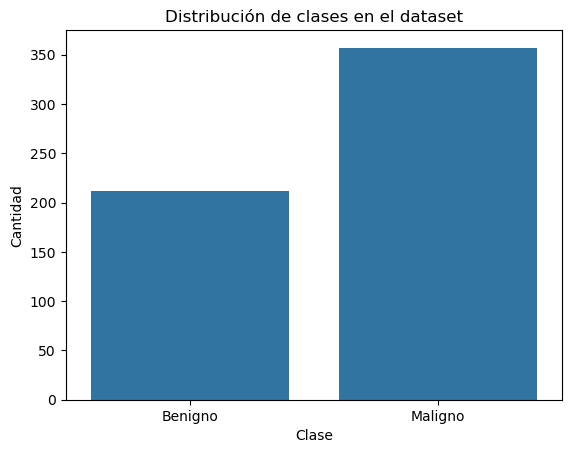

In [2]:
# Visualización de la distribución de clases
sns.countplot(x=y.map({0: "Benigno", 1: "Maligno"}))
plt.title("Distribución de clases en el dataset")
plt.xlabel("Clase")
plt.ylabel("Cantidad")
plt.show()

## 3. Modelos y técnicas utilizadas

Se emplean dos modelos principales:

- **Regresión Logística**: Modelo lineal para clasificación binaria.
- **MLPClassifier (Perceptrón Multicapa)**: Red neuronal feedforward.

Ambos modelos se integran en pipelines que incluyen estandarización de características. Para la optimización de hiperparámetros se utilizan:

- **Grid Search**: Búsqueda exhaustiva sobre un espacio definido de hiperparámetros.
- **Random Search**: Búsqueda aleatoria sobre un espacio de hiperparámetros, útil cuando el espacio es grande.

A continuación, se definen los pipelines y los espacios de búsqueda.

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# Pipeline para Regresión Logística
def RL_pipeline(random_state=42):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(solver='liblinear', max_iter=1000, random_state=random_state))
    ])

# Pipeline para MLPClassifier
def MLP_pipeline(random_state=42):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPClassifier(max_iter=2000, random_state=random_state))
    ])

In [4]:
from scipy.stats import loguniform

# Espacios de hiperparámetros
GRID_PARAMS_RL = {
    'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'clf__penalty': ['l1', 'l2']
}
RANDOM_PARAMS_RL = {
    'clf__C': loguniform(1e-4, 1e2),
    'clf__penalty': ['l1', 'l2']
}
GRID_PARAMS_MLP = {
    'mlp__hidden_layer_sizes': [(50,), (60,), (120, 60), (240, 120, 60)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': [0.00001, 0.0001, 0.001],
    'mlp__learning_rate_init': [0.001, 0.01]
}
RANDOM_PARAMS_MLP = {
    'mlp__hidden_layer_sizes': [(50,), (60,), (120, 60), (240, 120, 60)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': loguniform(1e-5, 1e-2),
    'mlp__learning_rate_init': loguniform(1e-3, 1e-1)
}

## 4. Resultados de Grid Search y Random Search

Se realiza la búsqueda de hiperparámetros para ambos modelos utilizando Grid Search y Random Search. Se evalúa el rendimiento mediante validación cruzada.

In [12]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

SEED = 40
N_FOLDS = 5

# División train/test para evaluación final
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# Regresión Logística
pipe_rl = RL_pipeline(random_state=SEED)

grid_rl = GridSearchCV(pipe_rl, GRID_PARAMS_RL, cv=N_FOLDS, scoring='accuracy', n_jobs=-1)
grid_rl.fit(X_train, y_train)

random_rl = RandomizedSearchCV(pipe_rl, RANDOM_PARAMS_RL, n_iter=50, cv=N_FOLDS, scoring='accuracy', random_state=SEED, n_jobs=-1)
random_rl.fit(X_train, y_train)

# MLPClassifier
pipe_mlp = MLP_pipeline(random_state=SEED)

grid_mlp = GridSearchCV(pipe_mlp, GRID_PARAMS_MLP, cv=N_FOLDS, scoring='accuracy', n_jobs=-1)
grid_mlp.fit(X_train, y_train)

random_mlp = RandomizedSearchCV(pipe_mlp, RANDOM_PARAMS_MLP, n_iter=50, cv=N_FOLDS, scoring='f1_macro', random_state=SEED, n_jobs=-1)
random_mlp.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('mlp',
                                              MLPClassifier(max_iter=2000,
                                                            random_state=40))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'mlp__activation': ['relu', 'tanh'],
                                        'mlp__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001D35C575940>,
                                        'mlp__hidden_layer_sizes': [(50,),
                                                                    (60,),
                                                                    (120, 60),
                                                                    (240, 120,
                                                                     60)],
                                        'mlp__learning_rate_init': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001D35C6B4D70>},
                   random_state=40, scoring='f1_macro')

In [13]:
# Mostrar mejores hiperparámetros encontrados
print("Mejores parámetros Regresión Logística (Grid Search):", grid_rl.best_params_)
print("Mejores parámetros Regresión Logística (Random Search):", random_rl.best_params_)
print("Mejores parámetros MLP (Grid Search):", grid_mlp.best_params_)
print("Mejores parámetros MLP (Random Search):", random_mlp.best_params_)

Mejores parámetros Regresión Logística (Grid Search): {'clf__C': 0.1, 'clf__penalty': 'l2'}
Mejores parámetros Regresión Logística (Random Search): {'clf__C': np.float64(0.1440114906597249), 'clf__penalty': 'l2'}
Mejores parámetros MLP (Grid Search): {'mlp__activation': 'relu', 'mlp__alpha': 1e-05, 'mlp__hidden_layer_sizes': (50,), 'mlp__learning_rate_init': 0.001}
Mejores parámetros MLP (Random Search): {'mlp__activation': 'tanh', 'mlp__alpha': np.float64(3.2683682442479127e-05), 'mlp__hidden_layer_sizes': (240, 120, 60), 'mlp__learning_rate_init': np.float64(0.03577263369365381)}


## 5. Evaluación en test set

Se evalúan los modelos optimizados sobre el conjunto de test y se muestran los reportes de clasificación y matrices de confusión.


Logistic Regression (Grid Search)
              precision    recall  f1-score   support

           0      1.000     0.976     0.988        42
           1      0.986     1.000     0.993        72

    accuracy                          0.991       114
   macro avg      0.993     0.988     0.991       114
weighted avg      0.991     0.991     0.991       114



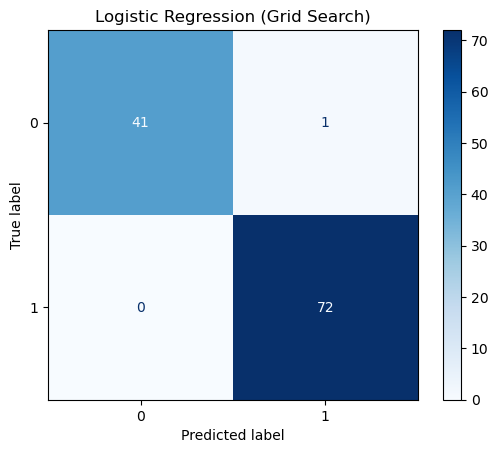

In [14]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

def plot_report_and_confusion(model, X_test, y_test, title):
    print(f"\n{title}")
    print("="*40)
    print(classification_report(y_test, model.predict(X_test), digits=3))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
    plt.title(title)
    plt.show()

plot_report_and_confusion(grid_rl, X_test, y_test, "Logistic Regression (Grid Search)")


Logistic Regression (Random Search)
              precision    recall  f1-score   support

           0      1.000     0.976     0.988        42
           1      0.986     1.000     0.993        72

    accuracy                          0.991       114
   macro avg      0.993     0.988     0.991       114
weighted avg      0.991     0.991     0.991       114



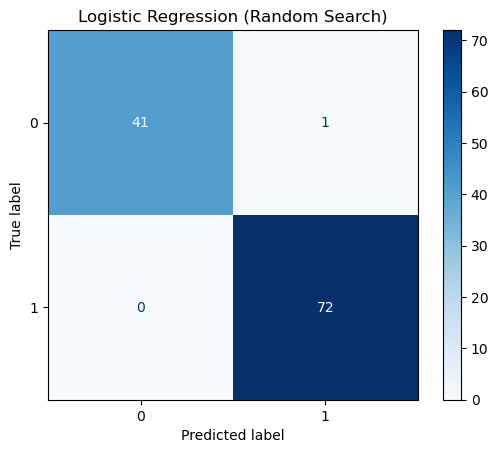

In [15]:
plot_report_and_confusion(random_rl, X_test, y_test, "Logistic Regression (Random Search)")


MLP Classifier (Grid Search)
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        42
           1      1.000     1.000     1.000        72

    accuracy                          1.000       114
   macro avg      1.000     1.000     1.000       114
weighted avg      1.000     1.000     1.000       114



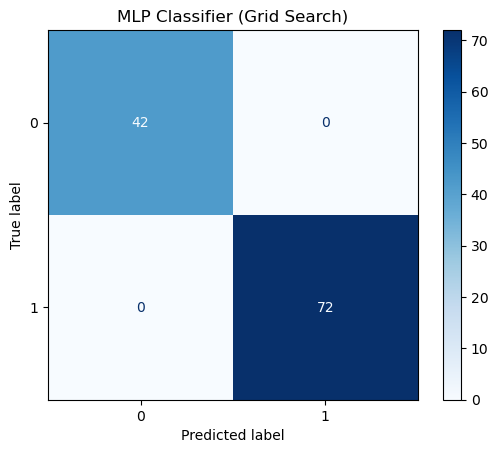

In [16]:
plot_report_and_confusion(grid_mlp, X_test, y_test, "MLP Classifier (Grid Search)")


MLP Classifier (Random Search)
              precision    recall  f1-score   support

           0      1.000     0.976     0.988        42
           1      0.986     1.000     0.993        72

    accuracy                          0.991       114
   macro avg      0.993     0.988     0.991       114
weighted avg      0.991     0.991     0.991       114



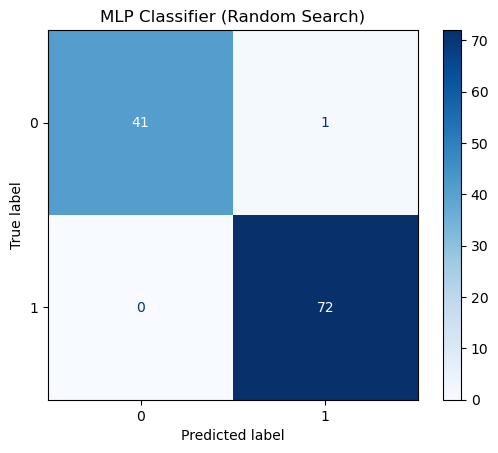

In [17]:
plot_report_and_confusion(random_mlp, X_test, y_test, "MLP Classifier (Random Search)")

## 6. Evaluación con Nested CV

Para obtener una estimación más robusta del rendimiento, se utiliza validación cruzada anidada (Nested CV).

In [26]:
from sklearn.model_selection import cross_val_score

def nested_cv_score(estimator, X, y, cv=5, scoring='accuracy', name="Modelo"):
    scores = cross_val_score(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    print(f"Nested CV {scoring.capitalize()} para {name}: {scores.mean():.3f} ± {scores.std():.3f}")
    # No retornamos scores para evitar impresión extra

# Nested CV para los mejores modelos
nested_cv_score(grid_rl.best_estimator_, X, y, cv=N_FOLDS, scoring='accuracy', name="Regresión Logística")
nested_cv_score(grid_mlp.best_estimator_, X, y, cv=N_FOLDS, scoring='accuracy', name="Multilayer Perceptron")

Nested CV Accuracy para Regresión Logística: 0.982 ± 0.006
Nested CV Accuracy para Multilayer Perceptron: 0.974 ± 0.005
Nested CV Accuracy para Multilayer Perceptron: 0.974 ± 0.005


## 7. Visualizaciones

A continuación, se muestra una visualización 3D de los datos proyectados mediante PCA, coloreando por clase. También se comparan los F1-score de los modelos.

In [2]:
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.io as pio
import pandas as pd
import os

# PCA 3D
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
df_pca['target'] = y.astype(str) if hasattr(y, 'astype') else [str(val) for val in y]

fig = px.scatter_3d(
    df_pca,
    x='PC1', y='PC2', z='PC3',
    color='target',
    title="Visualización PCA en 3D del dataset Breast Cancer",
    labels={'target': 'Clase'},
    color_discrete_sequence=px.colors.qualitative.Set1
)
fig.update_traces(marker=dict(
    size=5,
    opacity=0.7,
    line=dict(width=1, color='black')
))
# Rango de ejes
x_range = [df_pca['PC1'].min(), df_pca['PC1'].max()]
y_range = [df_pca['PC2'].min(), df_pca['PC2'].max()]
z_range = [df_pca['PC3'].min(), df_pca['PC3'].max()]
fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3',
        xaxis=dict(range=x_range),
        yaxis=dict(range=y_range),
        zaxis=dict(range=z_range)
    ),
    legend_title_text='Clase',
    legend=dict(
        font=dict(size=18),
        title_font=dict(size=20),
        itemsizing='constant'
    )
)
# Mostrar en notebook
pio.renderers.default = "notebook_connected"
fig.show()


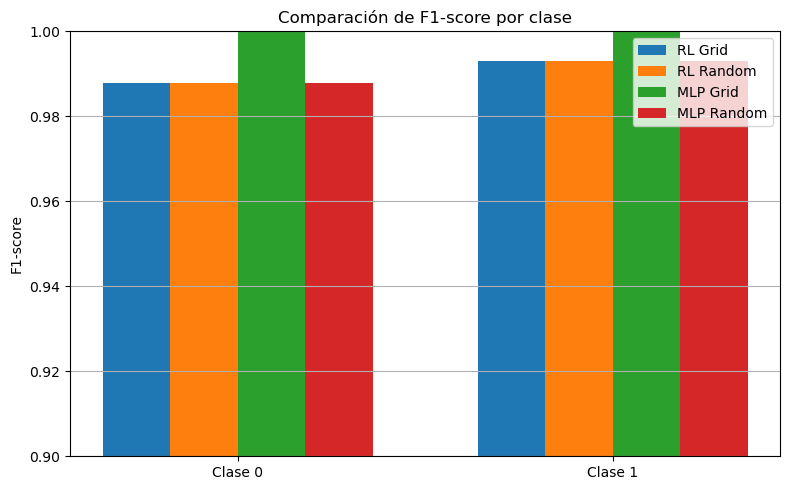

In [20]:
from sklearn.metrics import f1_score

# Comparación de F1-score por clase
preds_dict = {
    "RL Grid": grid_rl.predict(X_test),
    "RL Random": random_rl.predict(X_test),
    "MLP Grid": grid_mlp.predict(X_test),
    "MLP Random": random_mlp.predict(X_test)
}

f1_scores = {}
for name, preds in preds_dict.items():
    report = classification_report(y_test, preds, output_dict=True)
    f1_scores[name] = [report['0']['f1-score'], report['1']['f1-score']]

labels = ['Clase 0', 'Clase 1']
x = np.arange(len(labels))
bar_width = 0.18
offset = 0

plt.figure(figsize=(8, 5))
for i, (name, scores) in enumerate(f1_scores.items()):
    plt.bar(x + offset, scores, width=bar_width, label=name)
    offset += bar_width

plt.xticks(x + bar_width * (len(f1_scores) - 1) / 2, labels)
plt.ylabel('F1-score')
plt.title('Comparación de F1-score por clase')
plt.ylim(0.9, 1.0)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## 8. Conclusiones

- Ambos modelos logran un rendimiento sobresaliente en la clasificación del cáncer de mama, con F1-scores superiores al 0.98 en ambas clases.
- La optimización de hiperparámetros mediante Grid Search y Random Search produce resultados similares, aunque Random Search puede ser más eficiente en espacios grandes.
- La validación cruzada anidada confirma la robustez de los modelos y ayuda a evitar el sobreajuste.
- La visualización PCA 3D permite observar la separabilidad de las clases en el espacio reducido.

> **Nota importante:** No se debe confiar ciegamente en las métricas obtenidas a partir de un solo split de datos o de una única semilla aleatoria. Es posible obtener métricas artificialmente altas (incluso del 100%) si la partición de los datos resulta especialmente favorable. Por ello, es fundamental reportar métricas honestas y robustas, utilizando validación cruzada y, preferentemente, validación cruzada anidada. Así se evita la sobrestimación del rendimiento y se obtiene una evaluación más realista y generalizable del modelo.

Este pipeline puede ser fácilmente adaptado para otros datasets y problemas de clasificación biomédica.